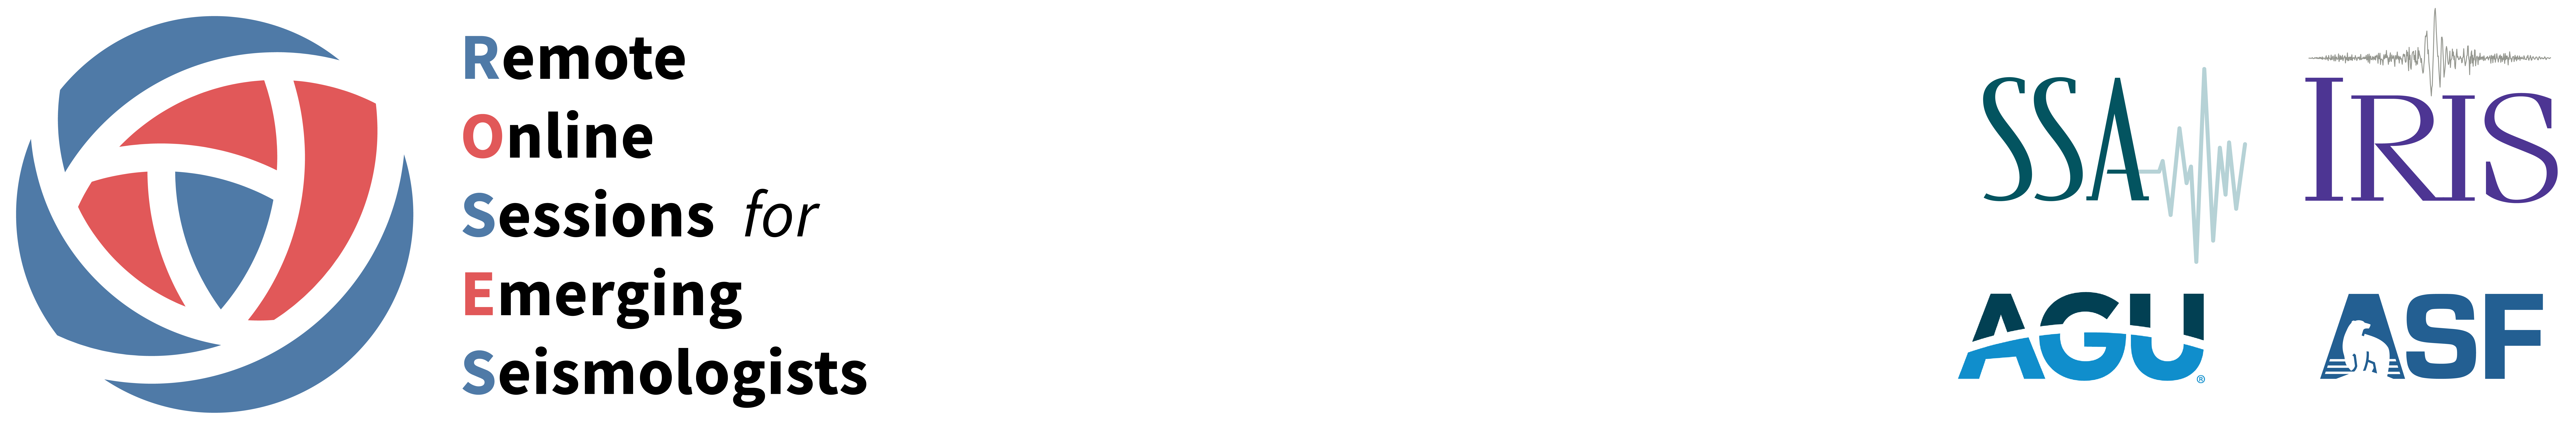

# ROSES 2021 - Earthquake Location - August 3rd 2021

*Presenter: Jonathan Smith (California Institute of Technology)*


Throughout this Remote Online Sessions for Emerging Seismologists (ROSES) course we will investigate earthquake location procedures with an outline to understanding ray-based earthquake location techniques. 

The course is separated into four main sections as outlined in the bullet list given below.

* **Installing Packages** - In this section we will `import` the packages used throughout this notebook.

*   **Multi-station Grid-Based Earthquake Location** - Outlining the synthetic problem used throughout this notebook. Defining the governing equations for ray-based travel-time for a given earthquake location. Outline an inversion procedure to determine an earthquake location without the inclusion of observational uncertainty.
*   **Probabilistic Earthquake Location** - Using the information learnt in the prior section we will now update the inversion procedure to include seismic station phase arrival uncertainty and predicted forward model uncertainties. An inversion procedure is then demonstrated using a Monte-Carlo inversion package PyMC3 to determine optimal earthquake location, now with the inclusion of location uncertainty

* **Discussion & Conclusion** - Discussion of how the methods learnt throughout this notebook scale to real-world problems, including: Complex Travel-Time Formulations, Increasing number of observations in the inversion procedure. Concluding remarks of the notebook




This course requires no pre-requesite for computational invastructure and will leverage the free interative python notebookes supplied by Google Colab

----
----

# Section 0 - Installing Packages and Pre-requisites

Outlined in this section in the pre-requisite packages required for running the software. 

In [1]:
import matplotlib.pylab as plt
import numpy as np
import itertools
import pymc3 as pm
import arviz as az
import seaborn as sns
from math import sqrt

# Section 1 - Multi-station Grid Based Earthquake Location

Lets consider the case of a seismic array composed of many individual stations locations. Then the predicted arrival time at each of the stations, $t_p^i$, can be written as:

$t_p^i = T(x_i,y_i,z_i,x_s,y_s,z_s) + t_0$

where $\vec{X}_i=[x_i,y_i,z_i]$ is the station location for station $i$, $\vec{X}_s=[x_s,y_s,z_s]$ the earthquake location, $T$ the travel-time function between the earthquake location and station location dependent on the subsurface velocity structure $V$, and $t_0$ the earthquake origin time. 

---------

The earthquake location can then be determined by minimising the misfit between a series of observed arrival times, $t_o$, across the seismic array, given by:


$ r = \sum_{i=1}^n |t_o^i - t_p^i|$

where $r$ in this case represents the L1-norm, $n$ represents the total number of station locations, $t_o^i$ the observed arrival time at station location $i$, and $t_p^i$ the predicted arrival time at station location $i$ given in the equation above. This misfit function is dependent on the four free parameters $[X_s,Y_s,Z_s,t_0]$. As $T$ is a non-linear function its not possible to solve $t_p^i$ as an analytical function.

------

Let's start by creating a 2-dimensional cross-section through the earth with a homogenous velocity model $V_H$.

We position a series of seismic stations on the Earths surface, $X_c$, and compute the predicted arrival time to the stations, $t_p^s$, from a random source location, $\vec{X}_s$. As the velocity model is homogenous the travel-time can be represented:

$T_{V_H}^i = \frac{\sqrt{\left( \vec{X_i}  - \vec{X_s}  \right)^2}}{V_H}$

where $T_V^i$ represents the travel-time for station $i$ dependent on velocity structure $V_H$. Even for this simple case notice the non-linear nature in $T_V^i$ dependent on the source location.

So now creating the station locations and plotting the setup on the problem.

In [2]:
# ---- Defining the domain of interest. ----
Xmin,Xmax,Zmin,Zmax = 0,30,-2,10
# X representing the horizontal distance in km
# Z representing the depth positive downwards in km

# ---- Seismic Station Locations ----
n                       = 25   # Number of seismic stations
n_error                 = 2    # Number of stations with erroneous results 
observation_uncertainty = 0.15 # Standard Deviation uncertainty in phase arrivals (all stations equal)

Xc      = np.zeros((n,2));
Xc[:,0] = np.random.uniform(low=Xmin, high=Xmax, size=(n))
Xc[:,1] = 0  # Setting stations at surface 

# --- Defining a random source location
Xs =  [np.random.uniform(low=Xmin, high=Xmax),
       np.random.uniform(low=0, high=Zmax)]

In [3]:
# --- Determining the observed travel-times for a single-phase ---
Vh = 3.1 #km/s

# Determining the observational Travel-Times assuming origin time t0=0.0
to = np.sqrt(np.sum(np.square(Xc - Xs),axis=1))/Vh

# Altering the observations to include some stations with large uncertainty
to[:n_error] = to[:n_error] + np.random.uniform(low=-0.5, high=+0.5, size=(to[:n_error].shape))
obs_sigma = np.ones(to.shape)*observation_uncertainty

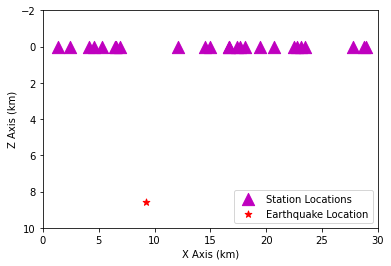

In [4]:
# Plotting Station Locations 
plt.scatter(Xc[:,0],Xc[:,1],s=150, c='m',marker='^',label='Station Locations')
# Plotting Source Location
plt.scatter(Xs[0],Xs[1],s=50,c='r',marker='*',label='Earthquake Location')
# Defining Axis lims and labels
plt.xlabel('X Axis (km)')
plt.ylabel('Z Axis (km)')
plt.xlim([Xmin,Xmax]); plt.ylim([Zmin,Zmax]); plt.gca().invert_yaxis()
plt.legend()

Now that we have created our synthetic case with observed arrivals times, lets now compute predicted travel-times on a grid structure and determine misfit with the synthetic observation times.

In [5]:
sep   = 0.1 #Search grid seperation 
Xg,Zg = np.meshgrid(np.arange(Xmin,Xmax+sep,sep),np.arange(Zmin,Zmax+sep,sep))
Xgf = Xg.flatten(); Zgf = Zg.flatten();

In [6]:
# --- Determining the Predicted travel-times from each grid cell to all the station locations
tp = np.zeros((n,len(Xgf)))
for ii in range(len(Xgf)):
  tp[:,ii] = np.sqrt(np.sum(np.square(Xc - np.array([Xgf[ii],Zgf[ii]])),axis=1))/Vh

In [7]:
# -- Determining the misfit between predicted and observed --
misfit = np.sum((tp-to[:,None])**2,axis=0)
misfit = misfit.reshape(Xg.shape)

Text(0.5, 1.0, 'Misfit Distance (km) = 0.158639307471418')

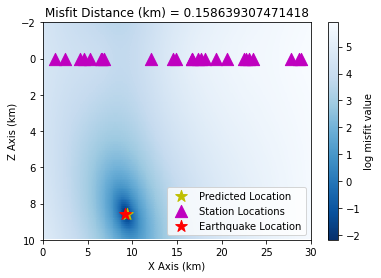

In [8]:
# -- Plotting the predicted location --
plt.pcolormesh(Xg-sep/2,Zg-sep/2,np.log(misfit),label='Log of misfit colourmap',cmap='Blues_r')
plt.colorbar(label='log misfit value')
plt.scatter(Xg.flatten()[np.argmin(misfit)],Zg.flatten()[np.argmin(misfit)],s=150,c='y',marker='*',label='Predicted Location')

# Plotting Station Locations 
plt.scatter(Xc[:,0],Xc[:,1],s=150, c='m',marker='^',label='Station Locations')
# Plotting Source Location
plt.scatter(Xs[0],Xs[1],s=150,c='r',marker='*',label='Earthquake Location')
# Defining Axis lims and labels
plt.xlabel('X Axis (km)')
plt.ylabel('Z Axis (km)')
plt.xlim([Xmin,Xmax]); plt.ylim([Zmin,Zmax]); plt.gca().invert_yaxis()
plt.legend()

plt.title('Misfit Distance (km) = {}'.format(np.sqrt(np.sum((np.array([Xg.flatten()[np.argmin(misfit)],Zg.flatten()[np.argmin(misfit)]])-Xs)**2))))


#### **Bonus Exercise 1** 
Investigate how changing grid-size affects the difference in the true and recovered earthquake locations. What interesting features do you note about the misfit space with changing seismic array geometries? 

In [9]:
# Code cell for user to work in

#### ***Bonus Exercise 2***
The synthetic problem currently neglects: multiple observational phases; complex velocity structures; and, observational uncertainty in arrivals and travel-time models. 
Although the last of these items will be addressed later in this notebook, the user should alter the above code to provide earthquake locations where each station has two phase arrivals, dependent on homogenous velocity structures of $V_H = 3.1$ and $V_H=4.5$ respectively for each of the phases  

In [10]:
# Code cell for user to work in

#### ***Bonus Exercise 3*** 
Try altering the code to include a origin time that is not a $t_0=0$. 
This will require the user to define another grid-search dimension representing the origin time. I recommend determining the misfit using $t_0=0$, then using the variation of $tp-to$ to define the grid-search maximum and minimum range.

In [11]:
# Code cell for user to work in

# Section 2 - Probabilistic Earthquake Location


## Section 2.1 - Introduction

In the previous section we supplied an inversion procedure reliant on observational and theoretical travel-times without uncertainty. In many scenarios the observational arrival times contain significant uncertainty related to the automated/manual phase arrival picking. In addition, understanding of the subsurface velocity requires prior geophysical analysis or regional context; as such also contains model based uncertainty. Throughout this section we will discussion the inclusion of uncertainty in the inversion for earthquake location. 

-----

## Section 2.2 - Inversion Theory

In our geophysical problem we wish to learn the unknown parameters describing the earthquake location, $p$, dependent on some observational data, $d$, given some theoretical relationship $\theta(d,p)$. Given the probabilistic formulation of inversion presented in Tarantola and Valette (1982) and discussed in detail in Lomax *et al.* (2000), we can formulate a posterior density function of the earthquake location and origin time. In this formulation the theoretical relationship and the observed arrival times are assumed to have Gaussian uncertainties, with a prior information that is uniform, then the posterior distribution, $p$, of the spatial location can be represented:


$p(\vec{x},t_0) \propto K \rho(\vec{x}) \cdot f(\vec{x},t_0)$


where $K$ is a normalising factor, $\rho(x)$ is the density function of prior on parameters, and $f(x)$ is the likelihood function. Discussed below we outline some of the main misfit functions.

----

## Section 2.3 - Likelihood Functions

**Gaussian Likelihood function**

The simplest misfit function is differencing based on a L2/RMS misfit function. Incorperating L2 misfit function into the PDF we get the formulation reduces to:


$f(\vec{x},t_0) = exp\left( -\frac{1}{2}\sum_{i}^{n} \frac{(t_o^i - t_p^i)^2}{\sigma_i} \right)$

where $K$ is the normalising factor, $t_o^i$ the observed arrival time at station location $i$, $t_p^i$ the predicted arrival time at station location $i$ and $\sigma_i$ is the variance of the data discussed in a Section 2.4 . $t_0$ is included in the calculation of the predicted arrival time.


*Advantages*

* Simple to compute
* Typically form simple unimodal posterior solutions

*Disadvantages*

* Highly effected by outlier observations
* Requires the determination of origin time in inversion

**Equal-Differential Time Likelihood function**

An alternative likelihood function is 
the Equal-Differential Time (Lomax et 
al, 2005), representing the 
differencing between observational 
pairs with the corresponding 
predicted pairs. This formulation 
looks at all pair-wise differences 
between the observations, increasing 
the number of observations in the 
inversion, and is independent of the 
origin time. The formulation can be 
represented:


$f(\vec{x}) = \left[ \sum_{i,j}^{n} \frac{1}{\sqrt{\sigma_i^2 + \sigma_j^2}} exp\left( \frac{[(t_o^i - t_o^i) - (t_p^i-t_p^j)]^2}{\sigma_i^2 + \sigma_j^2} \right) \right]^N$


*Advantages*

* Drastically reduces the affects from outlier observations
* Removes the need to include $t_0$ in inversion

*Disadvantages*

* Highly multimodal posterior space, creating issues for sampling algorithms
* Drastically increasing number of observations as pair-wise
* Differencing inside exponential, so tends to return `inf` for large differences  

**Laplacian Differential Time Likelihood function**

To reduce the amplitude of the multimodal distribution of the posterior for the Equal-Differential Likelihood function we can instead formulate the log-likelihood as that of a Laplacian differential time likelihood function. This represents the posterior space as a stacking of bands instead of hyperbolic surfaces. The equation then takes the form:


$f(\vec{x}) =  \sum_{i,j}^{n} \left[ \sqrt{2}\left|\frac{\left(t_{o}^i-t_{o}^j\right)-\left(t_{p}^i-t_{p}^j\right)}{\sqrt{\sigma_i^2+\sigma_j^2}}\right| + log\left( \frac{1}{\left(\sigma_i^2+\sigma_j^2 \right) \sqrt{2}}\right) \right]$ 



*Advantages* 

 * Drastically reduces the affects from outlier observations
 * Removes the need to include $t_0$ in inversion 
 * Stacking not dependent on hyperbolic fronts so does not trend to `inf` with large differences
 
*Disadvantages* 
 * Highly multimodal posterior space, creating issues for sampling algorithms
 * Drastically increasing number of observations as pair-wise
 

## Section 2.4 - Uncertainty in Posterior Distribution

The uncertainty in the posterior distribution is assigned as a combination of the observational, $\sigma_{obs}$, and forward model uncertainty, $\sigma_{pred}$, given as: 



$\sigma^2 = \sigma_{obs}^2 + \sigma_{pred}^2.$

The observational uncertainty represents uncertainty in each of the observational times, with an expected standard deviation for each observation time supplied by the user, dependent on phase arrival uncertainty. This value is then converted to a variance to define  $\sigma_{obs}$ for each observation.

The forward model uncertainty is constructed as a function of the predicted travel time for each of the observational locations (Similar to that given in Lomax et al 2000 for LOCGAU2, but that is a function of epicentral distance not time), given by:

\begin{equation}
\sigma_{pred}=\begin{cases}
			\sigma_{min}, & \text{for $\sigma_{f}T_{P} < \sigma_{min}$}\\
            \sigma_{frac}T_{pred}, & \text{for $\sigma_{min} \leq \sigma_{f}T_{P} \leq \sigma_{max}$}\\
            \sigma_{max}, & \text{for $\sigma_{f}T_{P} > \sigma_{max}$}\\
		 \end{cases}
\end{equation}

where $\sigma_{f}$ is the fraction of the travel time to use as uncertainty, bounded within the max and min uncertainties specified by $\sigma_{min}$ and $\sigma_{max}$ respectively. Throughout this work we use the $[\sigma_{f},\sigma_{min},\sigma_{max}] = [0.1,0.1s,2.0s]$, as given by:

In [12]:
Tpred_UncertaintyParams = [0.05,0.01,0.5]

## Section 2.5 - Inversion for Earthquake Location

Using the understanding learnt above we will investigate an inversion procedure for the same problem outlined in Section 1, but now with the inclusion of observational uncertainty. 


-----------------------------------------------------
----------- MCMC Parameter Estimation ---------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Sequential sampling (2 chains in 1 job)
HamiltonianMC: [Earthquake Z Location, Earthquake X Location]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 126 seconds.
The acceptance probability does not match the target. It is 0.7458110060234144, but should be close to 0.65. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.40201809535508326, but should be close to 0.65. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


-----------------------------------------------------
--------  Drawing Samples from Distribution -------- 


/usr/local/lib/python3.7/dist-packages/pymc3/sampling.py:1701: UserWarning: The effect of Potentials on other parameters is ignored during posterior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  UserWarning,


-----------------------------------------------------
-------------  Plotting and Summary  --------------- 


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.


                        mean     sd  hdi_3%  hdi_97%
Earthquake X Location  9.222  0.024   9.176    9.258
Earthquake Z Location  8.709  0.112   8.562    8.919


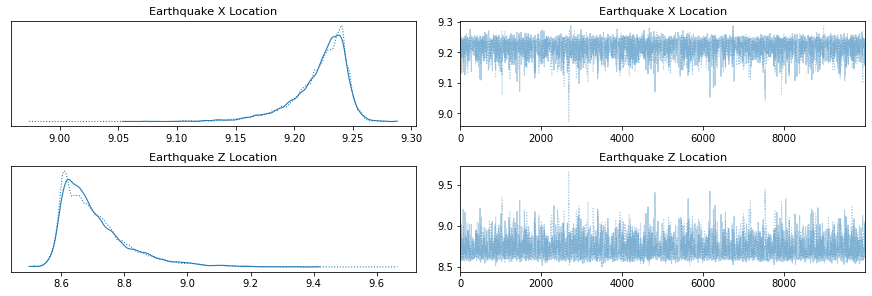

In [13]:
pairs     = np.array(list(itertools.combinations(np.arange(len(to)), 2)))
ix = pairs[:,0]
iy = pairs[:,1]

def likelihood(Tpred,Tobs,sigma):
  dtp    = (Tpred[ix]-Tpred[iy])
  dto    = (Tobs[ix]-Tobs[iy])
  dsigma = (sigma[ix]**2 + sigma[iy]**2)
  logp   = abs((dtp - dto)/(np.sqrt(dsigma)))*sqrt(2) + np.log(1/(dsigma*sqrt(2)))
  logp   = np.nansum(logp,axis=0)
  return -logp

def MCMC(likelihood,Params,draws=10000,tuning=1000,num_drawn_samples=1000,RANDOM_SEED=915623497):
    with pm.Model() as LocModel:
        Xe     = pm.Uniform('Earthquake X Location',lower=float(Params['X_Bounds'][0]),upper=float(Params['X_Bounds'][1]))
        Ze     = pm.Uniform('Earthquake Z Location',lower=float(Params['X_Bounds'][0]),upper=float(Params['Z_Bounds'][1]))

        # Defining the model predicted time uncertainties
        Tpred_Params = pm.Data('Tpred_Params',Params['Tpred_Params'])

        # Defining Observational Phase Pick Times & gaussian std uncertainties      
        Tobs       = pm.Data('Tobs',Params['Tobs'])
        Tobs_sigma = pm.Data('Tobs_sigma',Params['Tobs_sigma'])
        
        # Defining Station Locations 
        Xst    = pm.Data('Xst',Params['X_station'][:,0]);
        Zst    = pm.Data('Zst',Params['X_station'][:,1])
        
        # --- Determining the predicted travel-time ---
        Tpred  = (np.sqrt((Xst-Xe)**2 + (Zst-Ze)**2))/Vh

        # --- Determining the Posterior Uncertainty ---
        SigmaP = pm.math.clip(Tpred*Tpred_Params[0],Tpred_Params[1],Tpred_Params[2])
        
        SigmaO = Tobs_sigma
        sigma  = np.sqrt(SigmaO**2 + SigmaP**2)
          
        # -- Defining the likelihood function --
        like = pm.Potential('like',likelihood(Tpred,Tobs,sigma))

        # -- Hamiltonian Monte Carlo Sampling --
        print('-----------------------------------------------------')
        print('----------- MCMC Parameter Estimation ---------------')
        step = pm.HamiltonianMC()
        trace = pm.sample(draws=draws,tune=tuning,step=step)

        # -- Drawing Samples from the recovered distribution --
        print('-----------------------------------------------------')
        print('--------  Drawing Samples from Distribution -------- ')
        drawn_samples = pm.sample_posterior_predictive(trace, var_names=['Earthquake X Location', 'Earthquake Z Location'], random_seed=RANDOM_SEED,size=num_drawn_samples)

        # -- Plotting the distribution in the earthquake location and summary stats --
        print('-----------------------------------------------------')
        print('-------------  Plotting and Summary  --------------- ')
        pm.plots.traceplot(trace)
        summary = az.summary(trace, kind="stats")

    return trace,summary,drawn_samples



Params = {}
Params['X_Bounds']     = [Xmin,Xmax] # X dimension search region bounds
Params['Z_Bounds']     =[Zmin,Zmax] # Z dimension search region bounds
Params['X_station']    = Xc
Params['Tobs']         = to                #Observational Station Arrival Times
Params['Tobs_sigma']   = obs_sigma         #Observational Station Arrival Times Uncertainty
Params['Tpred_Params'] = Tpred_UncertaintyParams

trace,summary,drawn_samples = MCMC(likelihood,Params)
print(summary)


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


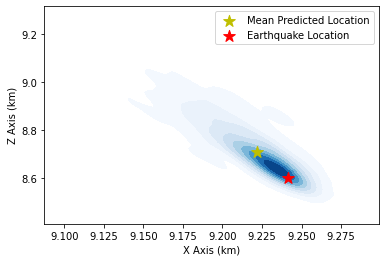

In [17]:
# Plotting the predicted location and colourmap of uncertainty
ax = plt.subplot(1,1,1)
quad1 = sns.kdeplot(drawn_samples['Earthquake X Location'][:1000],drawn_samples['Earthquake Z Location'][:1000],ax=ax,cmap='Blues',fill=True)
ax.scatter(summary['mean']['Earthquake X Location'],summary['mean']['Earthquake Z Location'],s=150,c='y',marker='*',label='Mean Predicted Location')
# Plotting Source Location
ax.scatter(Xs[0],Xs[1],s=150,c='r',marker='*',label='Earthquake Location')
# Defining Axis lims and labels
ax.set_xlabel('X Axis (km)')
ax.set_ylabel('Z Axis (km)')
plt.legend()

### Bonus Exercise 4

Currently the Laplacian differential time function is incorporated into the inversion procedure. Using the information given above replace this likelihood function with the that of the Equal-Differential Time. What issues lie in this formulation? How could the results differ?

In [15]:
# Code cell for user to work in

### Bonus Exercise 5

Generate a plot inspecting the difference between predicted travel-times and observed travel-times for all the stations.

**First** generate a scatter plot comprising all stations showing the their observed travel-time vs travel-time difference between observed and predicted travel-time for mean earthquake location ($t_o^i$ vs $(t_o^i - t_p^i)$).

**Second** Using the kernel-density function `sns.kdeplot` update the figure you created to include the uncerainty in the predicted traveltime estimations due to possible uncertainty in the earthquake location, the samples drawn from the MCMC procedure `drawn_samples`.

**Third** For each station scatter point include the observed phase arrival uncertainty `Tobs_sigma` as an errorbar in the y-dimenison. 

Using the created figure, answer the following questions:
1.   Are all observed station arrival travel-times within the uncertainty in predicted travel-time due from variation in possible earthquake location?
2.   If there are stations not within the uncertainty, where could the issue lie? Can you update the observational `sigma` to include this possible uncertainty in the prior?







In [16]:
# Code cell for user to work in

# Discussion and Concluding Remarks

Throughout this notebook we have gone through the methods required to do ray-based earthquake location inversion using a simple homogenous velocity model. 

In real-world geophysical problems some prior knowledge is known about the subsurface velocity structure, and as such more complex travel-time simulations are required. These travel-time simulations are typically constructed using the finite-difference forward modelling method to solve the partial differential Eikonal equation. In these formulations the travel-times from each station are determined to a grid of receiver points, through a user defined velocity structure (e.g. Podvin and Lecomte (1991)). In more recent work, machine learning based methods have been developed to solve the Eikonal Equation to determine the travel-time between any two points within a user defined velocity structure (Smith et al, 2020). Either of these two methods could be incorporated in the above code to replace the $Tpred$ in the Monte-Carlo inversion procedure.



Currently the simple example outlined in this notebook only determines the earthquake location in a two-dimensional problem. In a real-world geophysical problem, an additional dimension $Y$ would be included, also with the projection from local coordinate system (typically equal spacing in all dimensions, e.g. $km$) to global coordinate systems (e.g. Latitude/Longitude). 



Finally, the methods outlined in the notebook only demonstrate the earthquake location using a small number of seismic stations. For larger datasets, like that of a high-density seismic deployment or Distributed Acoustic Sensing, the increasing dataset size leads to a significant increase in the computational time for the inversion to determine the earthquake location and location uncertainty. As such these methods require computationally efficient posterior space sampling methods such as octree (NonLinLoc, Lomax et al 2000) or Stein Variational Gradient Descent (HypoSVI, Smith et al 2021).

# References

Podvin, P., and I. Lecomte (1991), 'Finite difference computation of traveltimes in very contrasted velocity models: a massively parallel approach and its associated tools', *Geophysical Journal International*, 105,1, 271–284


Lomax, A. (2005), ‘A reanalysis of the hypocentral location and related observations for the great 1906California earthquake’,*Bulletin of the Seismological Society of America*,95(3), 861–877.


Lomax, A., Virieux, J., Volant, P. & Berge-Thierry, C. (2000), 'Probabilistic Earthquake Location in 3Dand Layered Models', pp. 101–134.


Smith, J. D., Azizzadenesheli, K. & Ross, Z. E. (2020), ‘EikoNet: Solving the Eikonal Equation WithDeep Neural Networks’,IEEE Transactions on Geoscience and Remote Sensingpp. 1–12.


Tarantola A., & B. Valette (1982), 'Generalized nonlinear inverse problems solved using the least squares criterion', *Reviews of Geophysics*

